RGB images

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, applications, regularizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.patches as patches
from PIL import Image
import os
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, f1_score
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_file = "/content/drive/MyDrive/archive.zip"
extract_dir = "final_data"
if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
  os.makedirs(extract_dir, exist_ok=True)
  with zipfile.ZipFile(zip_file, 'r') as ref:
    ref.extractall(extract_dir)
  print('Extraction complete')
else:
    print("Extraction skipped/already exists.")

Extraction complete


In [4]:
#suppose we work with Thermal
classes = {'bike': 0, 'bus': 1, 'car': 2, 'person': 3, 'sign': 4, 'motor': 5, 'light': 6, 'truck': 7}

train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
    '/content/final_data/Train_RGB/train_rgb_patches', #path to your data
    labels='inferred',
    label_mode='int',
    class_names=list(classes.keys()),
    image_size=(64, 64),
    batch_size=512,
    shuffle=True,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/final_data/Val_RGB/val_rgb_patches',
    labels='inferred',
    label_mode='int',
    class_names=list(classes.keys()),
    image_size=(64, 64),
    batch_size=512,
    shuffle=False,
)

Found 108297 files belonging to 8 classes.
Found 10956 files belonging to 8 classes.


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# CNN model

In [6]:
# Custom CNN Model
from keras.regularizers import l2, l1_l2
cnn_model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  layers.Dropout(0.1),

  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Dropout(0.2),

  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D(2, 2),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  layers.Dropout(0.1),
  layers.Dense(8, activation='softmax')
])
optimizer = Adam(learning_rate = 0.001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,873,352 (52.92 MB)

 Trainable params: 13,873,352 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks, epochs=30, verbose=1)

Epoch 1/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 291ms/step - accuracy: 0.5001 - loss: 96.5809 - val_accuracy: 0.6667 - val_loss: 1.5365 - learning_rate: 0.0010
Epoch 2/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 177ms/step - accuracy: 0.6786 - loss: 1.4379 - val_accuracy: 0.7143 - val_loss: 1.3905 - learning_rate: 0.0010
Epoch 3/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.7664 - loss: 1.1339 - val_accuracy: 0.8101 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 4/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 177ms/step - accuracy: 0.8090 - loss: 0.9687 - val_accuracy: 0.8396 - val_loss: 0.8618 - learning_rate: 0.0010
Epoch 5/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.8287 - loss: 0.8734 - val_accuracy: 0.8541 - val_loss: 0.8094 - learning_rate: 0.0010
Epoch 6/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 177ms/step - accuracy: 0.8454 - loss: 0.7950 - val_accuracy: 0.8612 - val_loss: 0.7575 - learning_rate: 0.0010
Epoch 7/30
212/212 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.

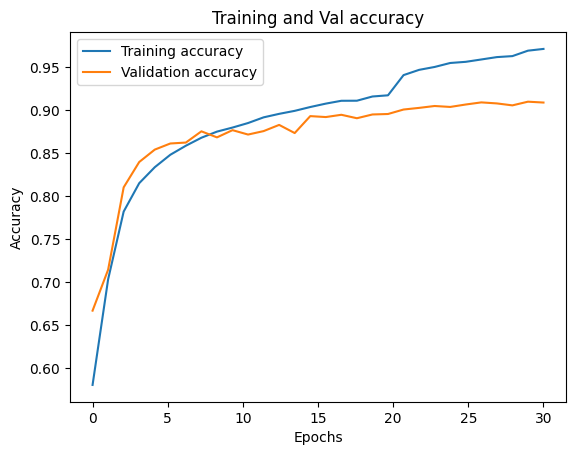

In [9]:
# training vs validation acc
plt.plot(np.linspace(0, len(cnn_history.history['accuracy']), len(cnn_history.history['accuracy'])), cnn_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(cnn_history.history['val_accuracy']), len(cnn_history.history['val_accuracy'])), cnn_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

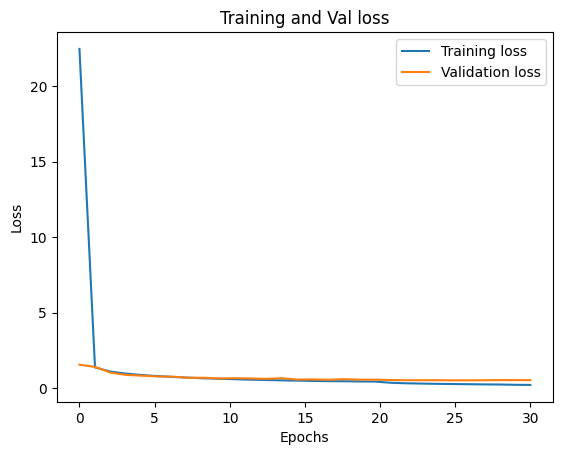

In [10]:
# training vs validation loss
plt.plot(np.linspace(0, len(cnn_history.history['loss']), len(cnn_history.history['loss'])), cnn_history.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(cnn_history.history['val_loss']), len(cnn_history.history['val_loss'])), cnn_history.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
cnn_preds = cnn_model.predict(val_dataset)
cnn_labels = cnn_preds.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [12]:
true_labels = []
class_names = val_dataset.class_names

for images, labels in val_dataset:
    true_labels.extend(labels.numpy())

In [13]:
import builtins
misclassified_indices_cnn = []

for i, (true_label, predicted_label) in enumerate(builtins.zip(true_labels, cnn_labels)):
    if true_label != predicted_label:
        misclassified_indices_cnn.append(i)

print("len Misclassified indices for cnn:", len(misclassified_indices_cnn))

len Misclassified indices for cnn: 1024


In [14]:
y_true = np.array(true_labels)
y_prob_pred = cnn_preds
y_pred = cnn_labels

In [15]:
np.save("CNNTrueLabelsRGB.npy", y_true)
np.save("CNNPredLabelsRGB.npy", y_pred)

Classification report for cnn validation: 

              precision    recall  f1-score   support

        bike     0.5336    0.7341    0.6180       173
         bus     0.7059    0.2712    0.3918       177
         car     0.9383    0.9658    0.9519      5527
      person     0.8855    0.9440    0.9138      2359
        sign     0.9152    0.8364    0.8740      1626
       motor     0.3654    0.3276    0.3455        58
       light     0.9255    0.8070    0.8622      1000
       truck     0.1667    0.1667    0.1667        36

    accuracy                         0.9065     10956
   macro avg     0.6795    0.6316    0.6405     10956
weighted avg     0.9066    0.9065    0.9038     10956

Accuracy: 0.9065
F1 Score: 0.6405
AUC: 0.9565


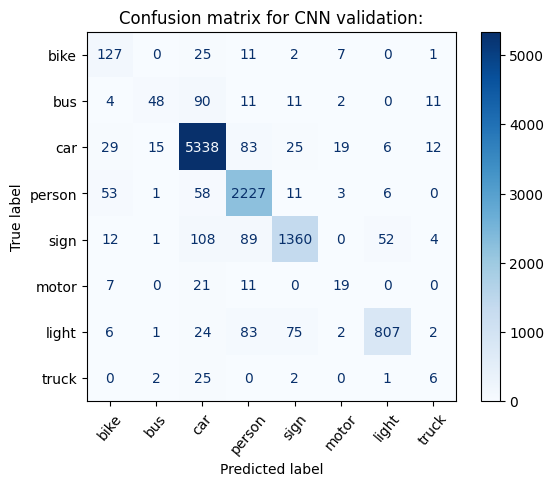

In [16]:
from sklearn.metrics import confusion_matrix
report = classification_report(y_true, y_pred, digits=4, target_names=val_dataset.class_names)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob_pred, multi_class='ovr')

print("Classification report for cnn validation: \n")
print(report)
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for CNN validation:")
plt.show()

In [17]:
cnn_model.save('/content/drive/MyDrive/Models/cnn_rgb_model.h5')

# vgg model

In [49]:
# Pretrained VGG16 Model

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers[:-6]:  # Fine-tune last 4 layers
    layer.trainable = False

vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])
optimizer = Adam(learning_rate = 0.0001)
vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [50]:
vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,072 (56.64 MB)

 Trainable params: 9,572,616 (36.52 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [51]:
vgg_history = vgg_model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks, epochs=8, verbose=1)

Epoch 1/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 36s 148ms/step - accuracy: 0.7949 - loss: 0.9739 - val_accuracy: 0.9263 - val_loss: 0.5082 - learning_rate: 1.0000e-04
Epoch 2/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - accuracy: 0.9379 - loss: 0.4564 - val_accuracy: 0.9333 - val_loss: 0.4360 - learning_rate: 1.0000e-04
Epoch 3/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - accuracy: 0.9553 - loss: 0.3497 - val_accuracy: 0.9409 - val_loss: 0.3753 - learning_rate: 1.0000e-04
Epoch 4/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.9678 - loss: 0.2749 - val_accuracy: 0.9453 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 5/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.9766 - loss: 0.2269 - val_accuracy: 0.9399 - val_loss: 0.3630 - learning_rate: 1.0000e-04
Epoch 6/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - accuracy: 0.9829 - loss: 0.1885 - val_accuracy: 0.9387 - val_loss: 0.3652 - learning_rate: 1.0000e-04
Epoch 7/8
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

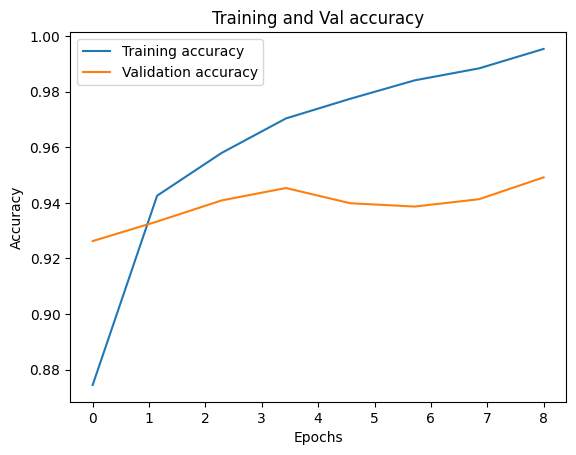

In [52]:
# training vs validation acc
plt.plot(np.linspace(0, len(vgg_history.history['accuracy']), len(vgg_history.history['accuracy'])), vgg_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(vgg_history.history['val_accuracy']), len(vgg_history.history['val_accuracy'])), vgg_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

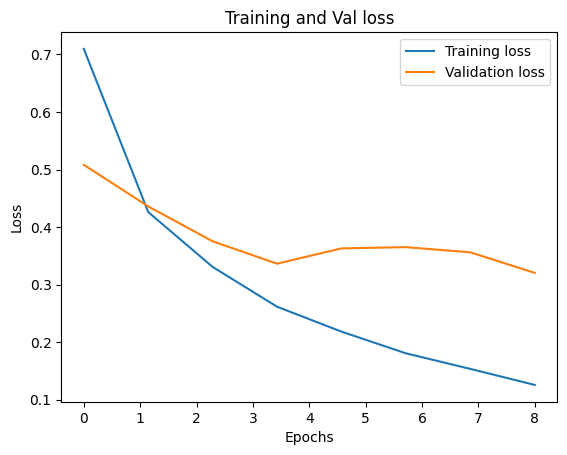

In [53]:
# training vs validation loss
plt.plot(np.linspace(0, len(vgg_history.history['loss']), len(vgg_history.history['loss'])), vgg_history.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(vgg_history.history['val_loss']), len(vgg_history.history['val_loss'])), vgg_history.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [54]:
vgg_preds = vgg_model.predict(val_dataset)
vgg_labels = vgg_preds.argmax(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step


In [55]:
vgg_true_labels = []

for images, labels in val_dataset:
    vgg_true_labels.extend(labels.numpy())

In [56]:
import builtins
misclassified_indices_vgg = []

for i, (true_label, predicted_label) in enumerate(builtins.zip(vgg_true_labels, vgg_labels)):
    if true_label != predicted_label:
        misclassified_indices_vgg.append(i)

print("len Misclassified indices for vgg:", len(misclassified_indices_vgg))

len Misclassified indices for vgg: 557


In [57]:
vgg_y_true = np.array(vgg_true_labels)
vgg_y_prob_pred = vgg_preds
vgg_y_pred = vgg_labels

In [58]:
np.save("VGGTrueLabelsRGB.npy", vgg_y_true)
np.save("VGGPredLabelsRGB.npy", vgg_y_pred)

Classification report for vgg validation: 

              precision    recall  f1-score   support

        bike     0.7784    0.7919    0.7851       173
         bus     0.8641    0.5028    0.6357       177
         car     0.9702    0.9837    0.9769      5527
      person     0.9509    0.9614    0.9562      2359
        sign     0.9245    0.9342    0.9293      1626
       motor     0.6200    0.5345    0.5741        58
       light     0.9563    0.8970    0.9257      1000
       truck     0.3684    0.5833    0.4516        36

    accuracy                         0.9492     10956
   macro avg     0.8041    0.7736    0.7793     10956
weighted avg     0.9494    0.9492    0.9483     10956

Accuracy: 0.9492
F1 Score: 0.7793
AUC: 0.9871


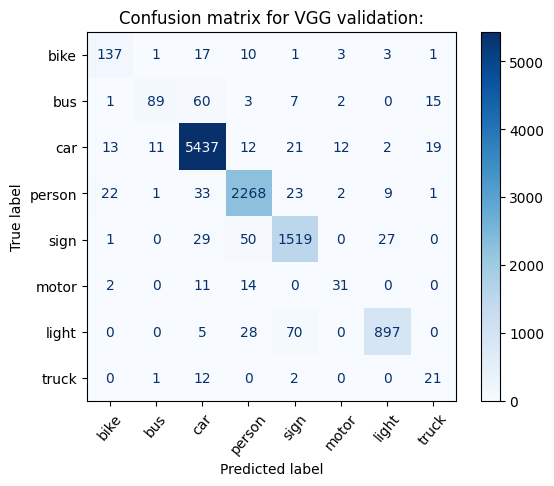

In [61]:
from sklearn.metrics import confusion_matrix
vgg_report = classification_report(vgg_y_true, vgg_y_pred, digits=4, target_names=class_names)
vgg_acc = accuracy_score(vgg_y_true, vgg_y_pred)
vgg_f1 = f1_score(vgg_y_true, vgg_y_pred, average='macro')
vgg_auc = roc_auc_score(vgg_y_true, vgg_y_prob_pred, multi_class='ovr')

print("Classification report for vgg validation: \n")
print(vgg_report)
print(f"Accuracy: {vgg_acc:.4f}")
print(f"F1 Score: {vgg_f1:.4f}")
print(f"AUC: {vgg_auc:.4f}")

cm_vgg = confusion_matrix(vgg_y_true, vgg_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for VGG validation:")
plt.show()

In [62]:
vgg_model.save('/content/drive/MyDrive/Models/vgg_RGBmodel.h5')

# Autoencoder

In [30]:
input = layers.Input(shape=(64, 64, 3))

l1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input)
l1 = layers.BatchNormalization()(l1)
l2 = layers.MaxPooling2D(2, padding='same')(l1)
l3 = layers.Dropout(0.3)(l2)
l4 = layers.Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l4 = layers.BatchNormalization()(l4)
l5 = layers.MaxPooling2D(2, padding='same')(l4)
l6 = layers.GlobalAveragePooling2D()(l5)
encoded = layers.Dense(128, activation='relu')(l6)
l7 = layers.Dense(16*16*64, activation='relu')(encoded)
l8 = layers.Reshape((16, 16, 64))(l7)
l9 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(l8)
decoder = layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(l9)

In [31]:
autoencoder = models.Model(input, decoder)
encoder = models.Model(input, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [32]:
normalization = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization(x), y))

In [33]:
autoen_train_dataset = train_dataset.map(lambda x, y: (x, x)) # Map input as both input and target
autoen_val_dataset = val_dataset.map(lambda x, y: (x, x)) # Map input as both input and target

In [34]:
autoencoder.fit(autoen_train_dataset,
                validation_data=autoen_val_dataset,
                epochs=100,
                callbacks=callbacks,
                verbose=1)

Epoch 1/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - loss: 0.0268 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 2/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0126 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0114 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 4/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0109 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0105 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 6/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0103 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 7/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0101 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 8/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0099 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 9/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - loss: 0.0097 - val_loss: 0.0101 - lear

In [35]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,676,619 (25.47 MB)

 Trainable params: 2,225,411 (8.49 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 4,450,824 (16.98 MB)

In [36]:
#extract features
def extract_features(dataset, encoder):
    features, labels = [], []
    for x_batch, y_batch in dataset:
        batch_features = encoder.predict(x_batch)
        features.append(batch_features)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels, axis=0)

x_train, y_train = extract_features(train_dataset, encoder)
x_val, y_val = extract_features(val_dataset, encoder)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1

In [37]:
# dense classifier for autoencoder
ae_model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)
ae_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
history_ae = ae_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6425 - loss: 1.1451 - val_accuracy: 0.8055 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 2/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7892 - loss: 0.6765 - val_accuracy: 0.8209 - val_loss: 0.5697 - learning_rate: 1.0000e-04
Epoch 3/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8091 - loss: 0.6112 - val_accuracy: 0.8315 - val_loss: 0.5390 - learning_rate: 1.0000e-04
Epoch 4/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8223 - loss: 0.5695 - val_accuracy: 0.8376 - val_loss: 0.5174 - learning_rate: 1.0000e-04
Epoch 5/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8270 - loss: 0.5527 - val_accuracy: 0.8393 - val_loss: 0.5115 - learning_rate: 1.0000e-04
Epoch 6/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8303 - loss: 0.5352 - val_accuracy: 0.8506 - val_loss: 0.4823 - learning_rate: 1.0000e-04
Epoch 7/100
3385/3385 ━━━━━━━━━━━━━━━━━━━━ 7s

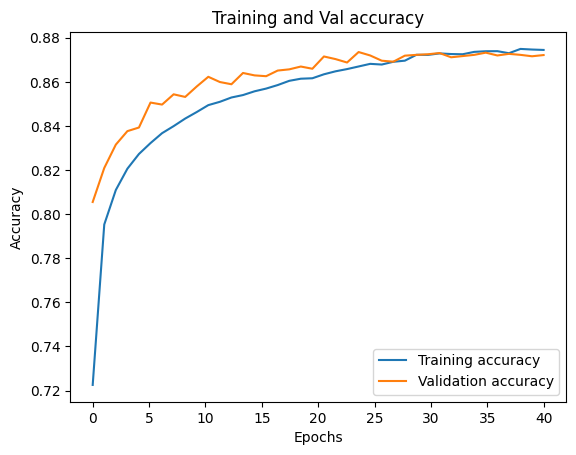

In [41]:
# training vs validation acc
plt.plot(np.linspace(0, len(history_ae.history['accuracy']), len(history_ae.history['accuracy'])), history_ae.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(history_ae.history['val_accuracy']), len(history_ae.history['val_accuracy'])), history_ae.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

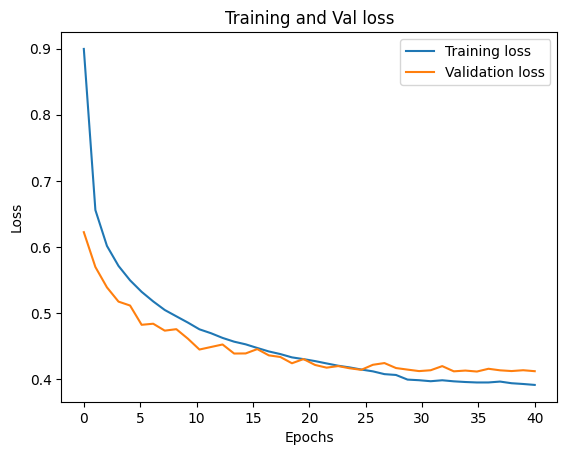

In [42]:
# training vs validation loss
plt.plot(np.linspace(0, len(history_ae.history['loss']), len(history_ae.history['loss'])), history_ae.history['loss'], label='Training loss')
plt.plot(np.linspace(0, len(history_ae.history['val_loss']), len(history_ae.history['val_loss'])), history_ae.history['val_loss'], label = 'Validation loss')
plt.title('Training and Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [43]:
ae_preds = ae_model.predict(x_val)
ae_labels = ae_preds.argmax(axis=1)

343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [44]:
# flatten true labels from validation set
ae_true_labels = y_val.flatten()

In [45]:
import builtins
misclassified_indices_ae = []

misclassified_indices_ae = [i for i, (t, p) in enumerate(zip(ae_true_labels, ae_labels)) if t != p]
print("len Misclassified indices for ae:", len(misclassified_indices_ae))

len Misclassified indices for ae: 1389


In [46]:
np.save("AETrueLabelsRGB.npy", ae_true_labels)
np.save("AEPredLabelsRGB.npy", ae_labels)

Classification report for ae validation: 

              precision    recall  f1-score   support

        bike     0.3692    0.4566    0.4083       173
         bus     0.5333    0.0452    0.0833       177
         car     0.8935    0.9720    0.9311      5527
      person     0.8536    0.8974    0.8750      2359
        sign     0.8876    0.7817    0.8313      1626
       motor     0.3500    0.1207    0.1795        58
       light     0.9153    0.7130    0.8016      1000
       truck     0.0000    0.0000    0.0000        36

    accuracy                         0.8732     10956
   macro avg     0.6003    0.4983    0.5138     10956
weighted avg     0.8661    0.8732    0.8634     10956

Accuracy: 0.8732
F1 Score: 0.5138
AUC: 0.9296


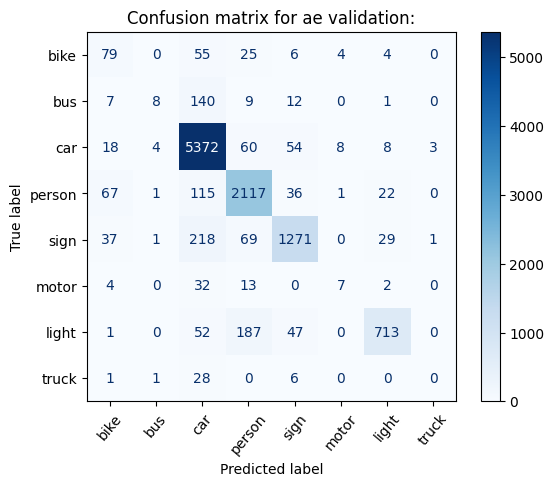

In [47]:
from sklearn.metrics import confusion_matrix
ae_report = classification_report(ae_true_labels, ae_labels, digits=4, target_names=class_names)
ae_acc = accuracy_score(ae_true_labels, ae_labels)
ae_f1 = f1_score(ae_true_labels, ae_labels, average='macro')
ae_auc = roc_auc_score(ae_true_labels, ae_preds, multi_class='ovr')

print("Classification report for ae validation: \n")
print(ae_report)
print(f"Accuracy: {ae_acc:.4f}")
print(f"F1 Score: {ae_f1:.4f}")
print(f"AUC: {ae_auc:.4f}")

cm_ae = confusion_matrix(ae_true_labels, ae_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ae, display_labels=class_names)
disp.plot(xticks_rotation=50, cmap='Blues')
plt.title("Confusion matrix for ae validation:")
plt.show()

In [48]:
autoencoder.save('/content/drive/MyDrive/Models/autoencoder_RGBmodel.h5')
ae_model.save('/content/drive/MyDrive/Models/ae_classifier_RGBmodel.h5')